In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
import numpy as np
from sklearn.datasets import make_classification

In [7]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [8]:
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                                          n_features=2, n_informative=1, 
                                                                          n_classes=2, n_redundant=0, 
                                                                          n_clusters_per_class=1,
                                                                          random_state=42)

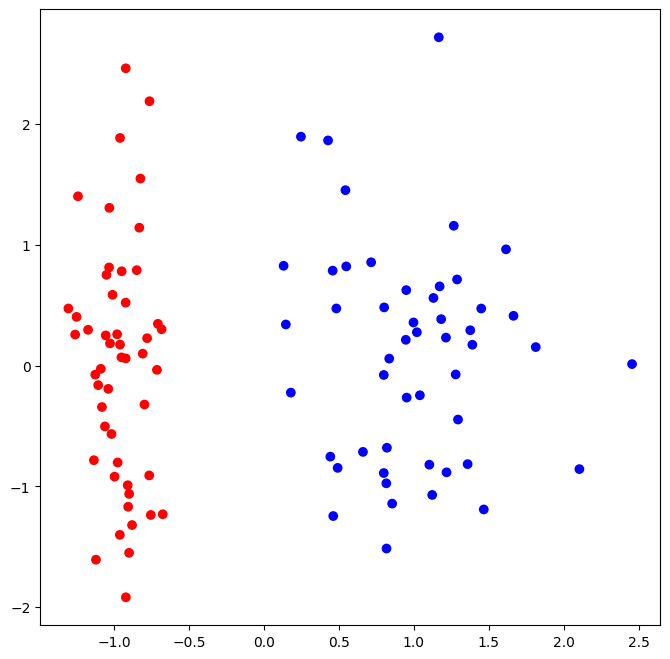

In [9]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [20]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                    classification_labels, 
                                                                                    test_size=0.3,
                                                                                    random_state=42)

In [21]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch


class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        prediction = max(classes, key=classes.get)
        return prediction

In [26]:
import random

random.seed(42)

def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
            classes[label] += 1

    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
    return impurity


def gain(left_labels, right_labels, root_gini):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)


def split(data, labels, column_index, t):
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
    return true_data, false_data, true_labels, false_labels

def get_subsample(len_sample):
    sample_indexes = list(range(len_sample))
    len_subsample = int(np.round(np.sqrt(len_sample)))
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)
    return subsample

def find_best_split(data, labels):
    root_gini = gini(labels)
    best_gain = 0
    best_index = best_t = None

    n_features = data.shape[1]
    feature_subsample_indices = get_subsample(n_features)

    for index in feature_subsample_indices:
        t_values = np.unique(data[:, index])
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            current_gain = gain(true_labels, false_labels, root_gini)

            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index


def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    return Node(index, t, true_branch, false_branch)

def get_bootstrap(data, labels, N):
       
    n_samples = data.shape[0]
    bootstrap = []

    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)

        # TODO: random.choice()
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))

    return bootstrap

def random_forest(data, labels, n_trees):
    
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

def classify_object(obj, node):
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

def tree_vote(forest, data):
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))

    predictions_per_obj = list(zip(*predictions))

    voted_predictions = []
    for obj in predictions_per_obj:
        voted_predictions.append(max(set(obj), key=obj.count))

    return voted_predictions

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Точность случайного леса из 1 деревьев на train: 82.857
Точность случайного леса из 1 деревьев на test: 73.333
CPU times: user 122 ms, sys: 5.15 ms, total: 127 ms
Wall time: 125 ms


Text(0.5, 1.0, 'Test accuracy=73.33')

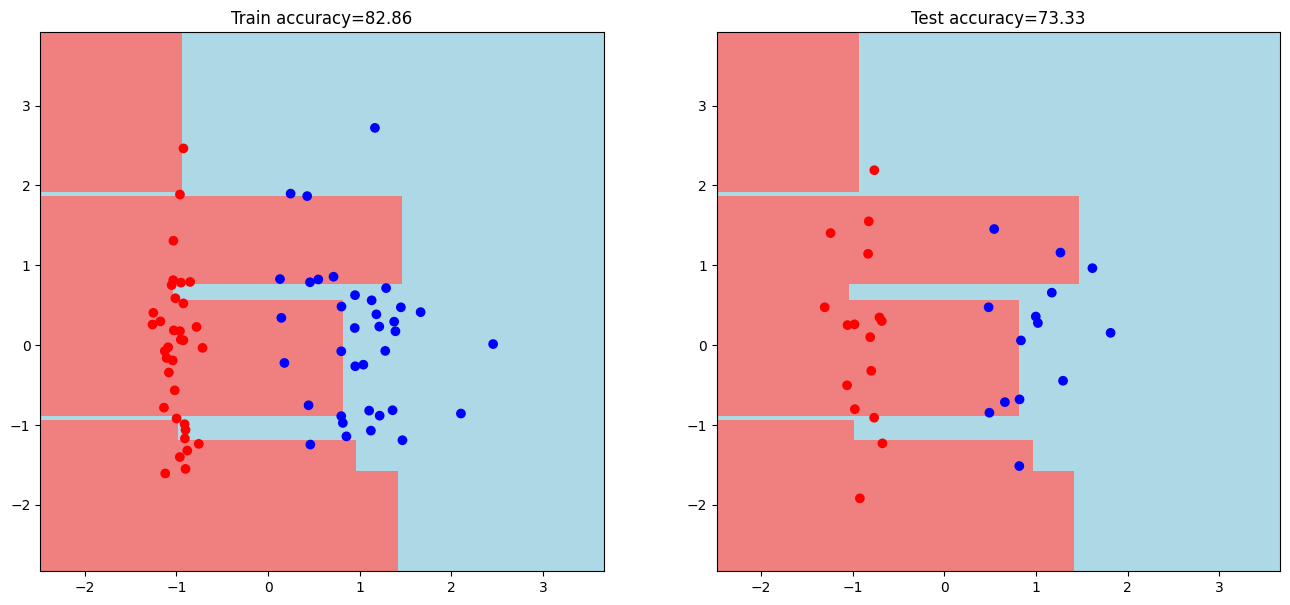

In [27]:
%%time
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

train_answs = tree_vote(my_forest_1, train_data)
test_answs = tree_vote(my_forest_1, test_data)

train_acc = accuracy_metric(train_labels, train_answs)
test_acc = accuracy_metric(test_labels, test_answs)

print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_acc:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_acc:.2f}')